# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
# need to mount with drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# using SQLite Table to read data.
#while using with drive copy the path from copy path by right clicking the database.sqlite file 
con = sqlite3.connect('drive/My Drive/Colab Notebooks/Assign - 3/database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000  """, con) 

def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [25]:
final.shape
#final.head(3)

(87773, 10)

In [26]:
# Combining all the above stundents and preprocessing the Review text data
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:39<00:00, 2199.72it/s]


In [27]:
# Combining all the above stundents and preprocessing the summary data
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 87773/87773 [00:28<00:00, 3067.37it/s]


In [28]:
#added preprocessed reviews
#sample_preproc_revi
final['PreprocessedText'] = preprocessed_reviews
final['PreprocessedSummary'] = preprocessed_summary
final['Final_Text'] = final['PreprocessedText'] + final['PreprocessedSummary']
final.head(3)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,PreprocessedText,PreprocessedSummary,Final_Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,made china,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...,dog lover delites,dogs love saw pet store tag attached regarding...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...,one fruitfly stuck,infestation fruitflies literally everywhere fl...


In [0]:
#sorting based on time
final["Time"] = pd.to_datetime(final["Time"],unit="s")
final = final.sort_values( by ="Time")

In [30]:
#splitting data into train , test
X_train, X_test, y_train, y_test = train_test_split(
    final['Final_Text'], final['Score'], test_size=0.30, random_state=0)

X_train_cv, X_cv, y_train_cv, y_cv = train_test_split(X_train, y_train, test_size=0.33) 

print(X_train.shape, y_train.shape)
print(X_train_cv.shape,y_train_cv.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)


(61441,) (61441,)
(41165,) (41165,)
(20276,) (20276,)
(26332,) (26332,)


In [34]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train_cv)

X_train_cv_bow = vectorizer.transform(X_train_cv)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_cv_bow.shape, y_train_cv.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(41165, 68770) (41165,)
(20276, 68770) (20276,)
(26332, 68770) (26332,)


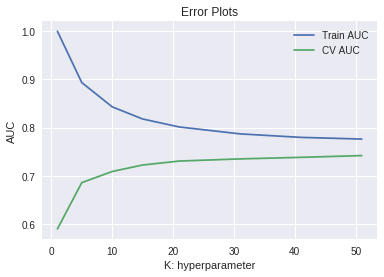

In [35]:
#finding best k- value using loop

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i , algorithm = "brute")
    neigh.fit(X_train_cv_bow, y_train_cv)
    y_train_pred = []
    y_train_pred.extend(neigh.predict_proba(X_train_cv_bow)[:,1])  
    y_cv_pred = []
    y_cv_pred.extend(neigh.predict_proba(X_cv_bow)[:,1])

    train_auc.append(roc_auc_score(y_train_cv,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()

In [0]:
best_k_bow = 51

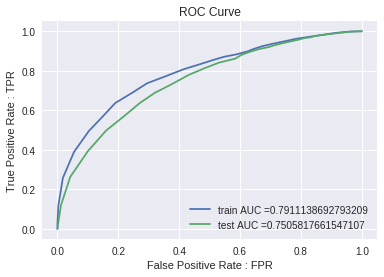

In [88]:
#testing the data
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k_bow)
neigh.fit(X_train_cv_bow, y_train_cv)


train_fpr, train_tpr, thresholds = roc_curve(y_train_cv, neigh.predict_proba(X_train_cv_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])

train_BOW_Acc = auc(train_fpr, train_tpr)
test_BOW_Acc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate : FPR")
plt.ylabel("True Positive Rate : TPR")
plt.title("ROC Curve")
plt.show()



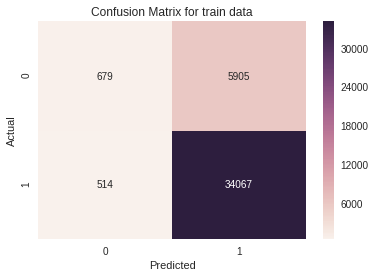

In [40]:
conf_matrix = confusion_matrix(y_train_cv, neigh.predict(X_train_cv_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

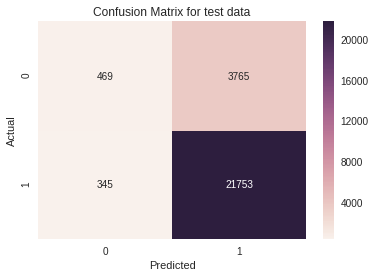

In [41]:
conf_matrix = confusion_matrix(y_test, neigh.predict(X_test_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [42]:
# Calculating TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test, neigh.predict(X_test_bow)).ravel()

# TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR " , TPR)

# FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR " , FPR)

# TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR " , TNR)

# FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR " , FNR)


TPR  0.8524570891135669
FPR  0.4238329238329238
TNR  0.5761670761670762
FNR  0.1475429108864331


To suit for best model , we need more TPR and TNR and less FPR and FNR.
from the above observation TPR and TNR are more and FPR and FNR are less.

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [44]:
#fitting to train data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train_cv)

X_train_tfidf = tf_idf_vect.transform(X_train_cv)
X_CV_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train_cv.shape)
print(X_CV_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)



After vectorizations
(41165, 24624) (41165,)
(20276, 24624) (20276,)
(26332, 24624) (26332,)


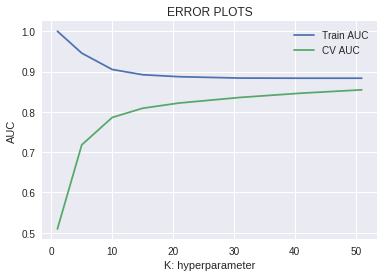

In [45]:
#finding best k- value using loop

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
  neigh = KNeighborsClassifier(n_neighbors=i,algorithm = "brute")
  neigh.fit(X_train_tfidf, y_train_cv)
  y_train_pred = []
  y_train_pred.extend(neigh.predict_proba(X_train_tfidf)[:,1])  
  y_cv_pred = []
  y_cv_pred.extend(neigh.predict_proba(X_CV_tfidf)[:,1])
  train_auc.append(roc_auc_score(y_train_cv,y_train_pred))
  cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
best_k_tfidf = 51

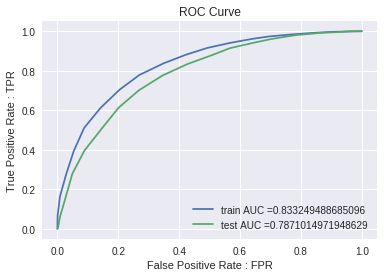

In [90]:
#testing the data
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k_tfidf)
neigh.fit(X_train_tfidf, y_train_cv)

train_fpr, train_tpr, thresholds = roc_curve(y_train_cv, neigh.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_tfidf)[:,1])

train_tfidf_Acc = auc(train_fpr, train_tpr)
test_tfidf_Acc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate : FPR")
plt.ylabel("True Positive Rate : TPR")
plt.title("ROC Curve")
plt.show()



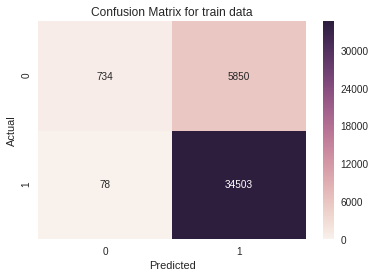

In [48]:
conf_matrix = confusion_matrix(y_train_cv, neigh.predict(X_train_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

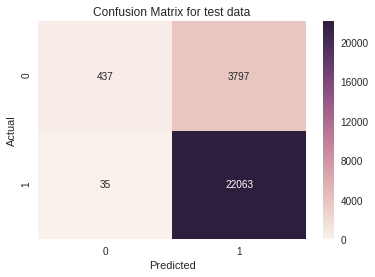

In [49]:
conf_matrix = confusion_matrix(y_test, neigh.predict(X_test_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [50]:
# Calculating TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test, neigh.predict(X_test_tfidf)).ravel()

# TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR " , TPR)

# FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR " , FPR)

# TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR " , TNR)

# FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR " , FNR)


TPR  0.8531709203402938
FPR  0.07415254237288135
TNR  0.9258474576271186
FNR  0.1468290796597061


### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [52]:
# Train your own Word2Vec model using your own text corpus

X_train_sentance=[]
for sentance in X_train_cv:
    X_train_sentance.append(sentance.split())
 
X_test_sentance=[]
for sentance in X_test:
    X_test_sentance.append(sentance.split())

X_cv_sentance=[]
for sentance in X_cv:
    X_cv_sentance.append(sentance.split())
    
w2v_model=Word2Vec(X_train_sentance,min_count=5,size=100, workers=4)


w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

X_train_vectors = []
for sent in X_train_sentance:
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_vectors.append(sent_vec)
    

X_test_vectors = []
for sent in X_test_sentance:
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_vectors.append(sent_vec)
    
  
X_cv_vectors = []
for sent in X_cv_sentance:
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_vectors.append(sent_vec)
    


number of words that occured minimum 5 times  12938


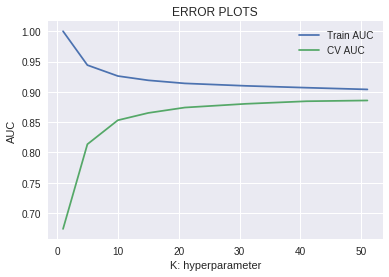

In [53]:
#finding best k- value using loop

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
  neigh = KNeighborsClassifier(n_neighbors=i,algorithm = "brute")
  neigh.fit(X_train_vectors, y_train_cv)
  y_train_pred = []
  y_train_pred.extend(neigh.predict_proba(X_train_vectors)[:,1])  
  y_cv_pred = []
  y_cv_pred.extend(neigh.predict_proba(X_cv_vectors)[:,1])
  train_auc.append(roc_auc_score(y_train_cv,y_train_pred))
  cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
best_k_AVGW2V = 51

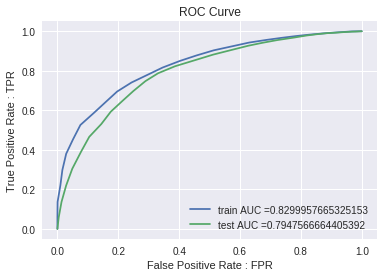

In [92]:
#testing the data
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k_AVGW2V)
neigh.fit(X_train_vectors, y_train_cv)

train_fpr, train_tpr, thresholds = roc_curve(y_train_cv, neigh.predict_proba(X_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_vectors)[:,1])

train_AVGW2V_Acc = auc(train_fpr, train_tpr)
test_AVGW2V_Acc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate : FPR")
plt.ylabel("True Positive Rate : TPR")
plt.title("ROC Curve")
plt.show()



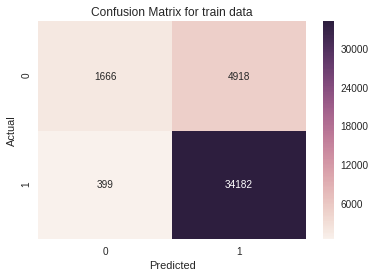

In [56]:
conf_matrix = confusion_matrix(y_train_cv, neigh.predict(X_train_vectors))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

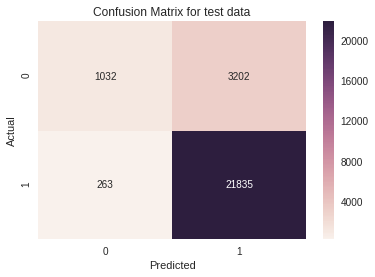

In [57]:
conf_matrix = confusion_matrix(y_test, neigh.predict(X_test_vectors))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [58]:
# Calculating TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test, neigh.predict(X_test_vectors)).ravel()

# TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR " , TPR)

# FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR " , FPR)

# TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR " , TNR)

# FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR " , FNR)


TPR  0.8721092782681631
FPR  0.2030888030888031
TNR  0.7969111969111969
FNR  0.12789072173183688


### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [60]:
# Please write all the code with proper documentation

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
      
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidfw2v.append(sent_vec)
    row += 1
    
    
X_test_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidfw2v.append(sent_vec)
    row += 1
    
    
    
X_cv_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_cv_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_cv_tfidfw2v.append(sent_vec)
    row += 1

100%|██████████| 20276/20276 [10:48<00:00, 31.28it/s]


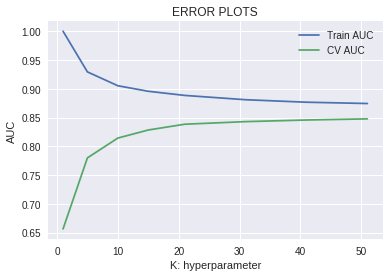

In [61]:
#finding best k- value using loop

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
  neigh = KNeighborsClassifier(n_neighbors=i,algorithm = "brute")
  neigh.fit(X_train_tfidfw2v, y_train_cv)
  y_train_pred = []
  y_train_pred.extend(neigh.predict_proba(X_train_tfidfw2v)[:,1])  
  y_cv_pred = []
  y_cv_pred.extend(neigh.predict_proba(X_cv_tfidfw2v)[:,1])
  train_auc.append(roc_auc_score(y_train_cv,y_train_pred))
  cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
best_k_tfidfW2V = 51

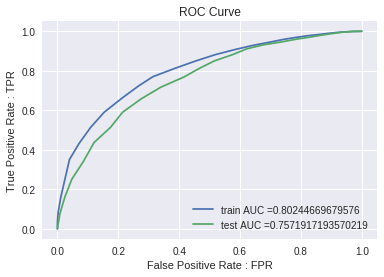

In [94]:
#testing the data

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k_tfidfW2V)
neigh.fit(X_train_tfidfw2v, y_train_cv)

train_fpr, train_tpr, thresholds = roc_curve(y_train_cv, neigh.predict_proba(X_train_tfidfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_tfidfw2v)[:,1])

train_tfidfW2V_Acc = auc(train_fpr, train_tpr)
test_tfidfW2V_Acc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate : FPR")
plt.ylabel("True Positive Rate : TPR")
plt.title("ROC Curve")
plt.show()



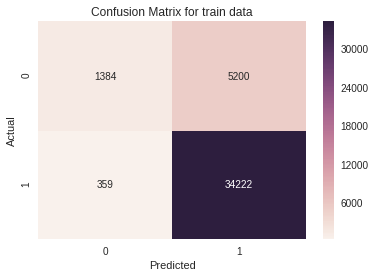

In [64]:
conf_matrix = confusion_matrix(y_train_cv, neigh.predict(X_train_tfidfw2v))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

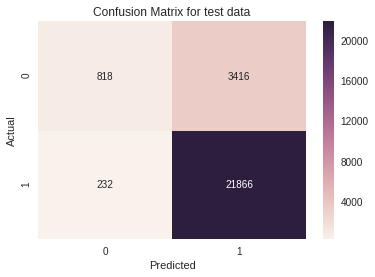

In [65]:
conf_matrix = confusion_matrix(y_test, neigh.predict(X_test_tfidfw2v))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [66]:
# Calculating TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test, neigh.predict(X_test_tfidfw2v)).ravel()

# TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR " , TPR)

# FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR " , FPR)

# TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR " , TNR)

# FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR " , FNR)


TPR  0.8648841072699944
FPR  0.22095238095238096
TNR  0.7790476190476191
FNR  0.13511589273000554


## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [0]:
# Please write all the code with proper documentation

In [68]:
final.shape
#final.head(3)

(87773, 13)

In [0]:
final_25k = final[: 25000]

In [27]:
final_25k.shape

(25000, 10)

In [28]:
# Combining all the above stundents and preprocessing the Review text data
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final_25k['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 25000/25000 [00:10<00:00, 2325.43it/s]


In [29]:
# Combining all the above stundents and preprocessing the summary data
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final_25k['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 25000/25000 [00:08<00:00, 3101.25it/s]


In [30]:
#added preprocessed reviews
#sample_preproc_revi
final_25k['PreprocessedText'] = preprocessed_reviews
final_25k['PreprocessedSummary'] = preprocessed_summary
final_25k['Final_Text'] = final_25k['PreprocessedText'] + final_25k['PreprocessedSummary']
final_25k.head(3)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,PreprocessedText,PreprocessedSummary,Final_Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,made china,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...,dog lover delites,dogs love saw pet store tag attached regarding...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...,one fruitfly stuck,infestation fruitflies literally everywhere fl...


In [0]:
#sorting based on time
final_25k["Time"] = pd.to_datetime(final_25k["Time"],unit="s")
final_25k = final_25k.sort_values( by ="Time")

In [32]:
#splitting data into train , test
X_train, X_test, y_train, y_test = train_test_split(
    final_25k['Final_Text'], final_25k['Score'], test_size=0.30, random_state=0)

X_train_cv, X_cv, y_train_cv, y_cv = train_test_split(X_train, y_train, test_size=0.33) 

print(X_train.shape, y_train.shape)
print(X_train_cv.shape,y_train_cv.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)


(17500,) (17500,)
(11725,) (11725,)
(5775,) (5775,)
(7500,) (7500,)


In [33]:
from sklearn.decomposition import  TruncatedSVD
vectorizer = CountVectorizer(min_df=10, max_features=500)
vectorizer.fit(X_train_cv)

X_train_cv_bow = vectorizer.transform(X_train_cv)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

svd = TruncatedSVD(n_components=100)


x_train_dense_bow = svd.fit_transform(X_train_cv_bow)
x_test_dense_bow = svd.transform(X_test_bow)
x_cv_dense_bow = svd.transform(X_cv_bow)

print("After vectorizations")
print(x_train_dense_bow.shape, y_train_cv.shape)
print(x_cv_dense_bow.shape, y_cv.shape)
print(x_test_dense_bow.shape, y_test.shape)

After vectorizations
(11725, 100) (11725,)
(5775, 100) (5775,)
(7500, 100) (7500,)


In [34]:
print(type(x_train_dense_bow))
print(type(x_cv_dense_bow))
print(type(x_test_dense_bow))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


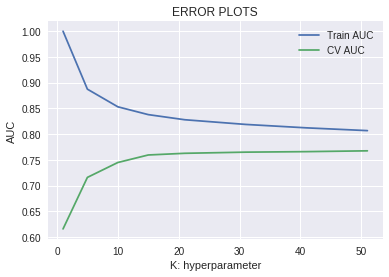

In [35]:
#finding best k- value using loop

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i , algorithm = "kd_tree")
    neigh.fit(x_train_dense_bow, y_train_cv)
    
    y_train_pred = []
    y_train_pred.extend(neigh.predict_proba(x_train_dense_bow)[:,1])  
    y_cv_pred = []
    y_cv_pred.extend(neigh.predict_proba(x_cv_dense_bow)[:,1])


    train_auc.append(roc_auc_score(y_train_cv,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))


plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
best_K_KD_BOW = 51

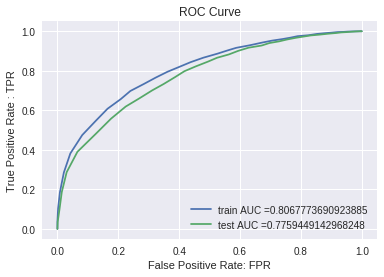

In [96]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_K_KD_BOW,algorithm = "kd_tree")
neigh.fit(x_train_dense_bow, y_train_cv)

train_fpr, train_tpr, thresholds = roc_curve(y_train_cv, neigh.predict_proba(x_train_dense_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test_dense_bow)[:,1])

train_BOW_KD_Acc = auc(train_fpr, train_tpr)
test_BOW_KD_Acc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate: FPR")
plt.ylabel("True Positive Rate : TPR")
plt.title("ROC Curve")
plt.show()

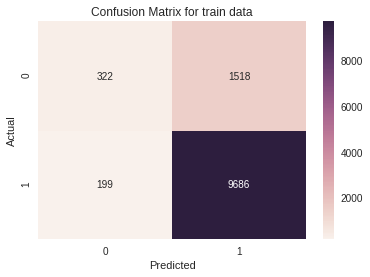

In [38]:
conf_matrix = confusion_matrix(y_train_cv, neigh.predict(x_train_dense_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

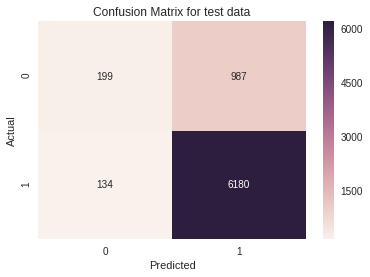

In [40]:
conf_matrix = confusion_matrix(y_test, neigh.predict(x_test_dense_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [41]:
# Calculating TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test, neigh.predict(x_test_dense_bow)).ravel()

# TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR " , TPR)

# FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR " , FPR)

# TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR " , TNR)

# FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR " , FNR)


TPR  0.8622854750941816
FPR  0.4024024024024024
TNR  0.5975975975975976
FNR  0.13771452490581834


### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [0]:
# Please write all the code with proper documentation

In [43]:
#fitting to train data
tf_idf_vect = TfidfVectorizer(min_df=10 , max_features=500)
tf_idf_vect.fit(X_train_cv)

X_train_tfidf = tf_idf_vect.transform(X_train_cv)
X_CV_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

svd2 = TruncatedSVD(n_components=100)

x_train_dense_tfidf = svd2.fit_transform(X_train_tfidf)
x_cv_dense_tfidf = svd2.transform(X_CV_tfidf)
x_test_dense_tfidf = svd2.transform(X_test_tfidf)

print("After vectorizations")
print(x_train_dense_tfidf.shape, y_train_cv.shape)
print(x_cv_dense_tfidf.shape, y_cv.shape)
print(x_test_dense_tfidf.shape, y_test.shape)



After vectorizations
(11725, 100) (11725,)
(5775, 100) (5775,)
(7500, 100) (7500,)


In [44]:
print(type(x_train_dense_tfidf))
print(type(x_cv_dense_tfidf))
print(type(x_test_dense_tfidf))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


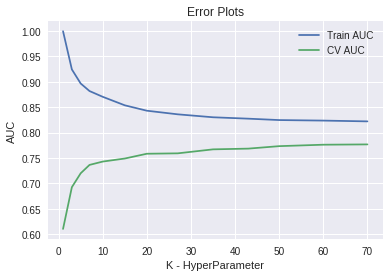

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc=[]
k=[1,3,5,7,10,15,20,27,35,43,50,60,70]
for i in k:
  neigh = KNeighborsClassifier(n_neighbors=i , algorithm="kd_tree")
  neigh.fit(x_train_dense_tfidf,y_train_cv)
  y_train_pred = []
  y_train_pred.extend(neigh.predict_proba(x_train_dense_tfidf)[:,1])
  y_cv_pred = []
  y_cv_pred.extend(neigh.predict_proba(x_cv_dense_tfidf)[:,1])
  
  train_auc.append(roc_auc_score(y_train_cv,y_train_pred))
  cv_auc.append(roc_auc_score(y_cv , y_cv_pred))
  
  
plt.plot(k,train_auc , label = 'Train AUC')
plt.plot(k,cv_auc , label = 'CV AUC')
plt.legend()
plt.xlabel("K - HyperParameter")
plt.ylabel("AUC")
plt.title("Error Plots")
plt.show()



In [0]:
best_k_KD_tfidf = 35 # as the k value , this will leads to overfitting

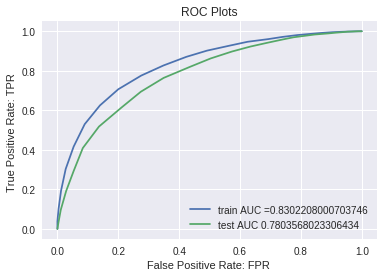

In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc

neigh = KNeighborsClassifier(n_neighbors=best_k_KD_tfidf,algorithm = "kd_tree")
neigh.fit(x_train_dense_tfidf,y_train_cv)

train_fpr , train_tpr , thresholds = roc_curve(y_train_cv , neigh.predict_proba(x_train_dense_tfidf)[:,1])
test_fpr , test_tpr , thresholds = roc_curve(y_test, neigh.predict_proba(x_test_dense_tfidf)[:,1])

train_tfidf_KD_Acc = auc(train_fpr,train_tpr)
test_tfidf_KD_Acc = auc(test_fpr,test_tpr)

plt.plot(train_fpr , train_tpr , label = "train AUC ="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr , test_tpr , label = "test AUC "+ str(auc(test_fpr,test_tpr)))
plt.legend()
plt.xlabel( "False Positive Rate: FPR " )
plt.ylabel("True Positive Rate: TPR ")
plt.title("ROC Plots")
plt.show()

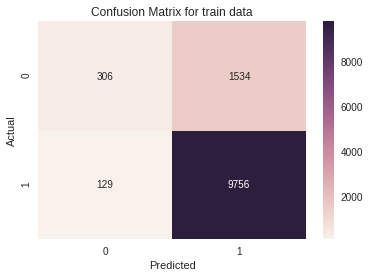

In [48]:
conf_matrix = confusion_matrix(y_train_cv, neigh.predict(x_train_dense_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

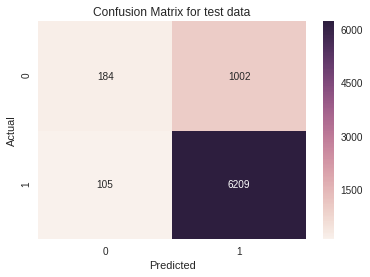

In [49]:
conf_matrix = confusion_matrix(y_test, neigh.predict(x_test_dense_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [50]:
# Calculating TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test, neigh.predict(x_test_dense_tfidf)).ravel()

# TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR " , TPR)

# FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR " , FPR)

# TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR " , TNR)

# FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR " , FNR)


TPR  0.8610456247399806
FPR  0.3633217993079585
TNR  0.6366782006920415
FNR  0.1389543752600194


### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [52]:
# Train your own Word2Vec model using your own text corpus

X_train_sentance=[]
for sentance in X_train_cv:
    X_train_sentance.append(sentance.split())
 
X_test_sentance=[]
for sentance in X_test:
    X_test_sentance.append(sentance.split())

X_cv_sentance=[]
for sentance in X_cv:
    X_cv_sentance.append(sentance.split())
    
w2v_model=Word2Vec(X_train_sentance,min_count=5,size=100, workers=4)


w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

X_train_vectors = []
for sent in X_train_sentance:
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_vectors.append(sent_vec)
    

X_test_vectors = []
for sent in X_test_sentance:
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_vectors.append(sent_vec)
    
  
X_cv_vectors = []
for sent in X_cv_sentance:
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_vectors.append(sent_vec)
    


number of words that occured minimum 5 times  6800


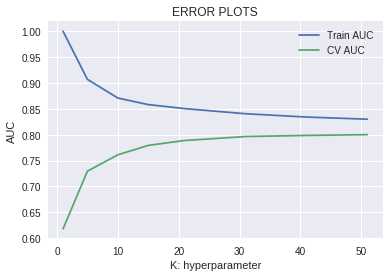

In [53]:
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")
    neigh.fit(X_train_vectors, y_train_cv)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_vectors)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_vectors)[:,1]
    
    train_auc.append(roc_auc_score(y_train_cv,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
best_k_KD_AvgW2V = 51

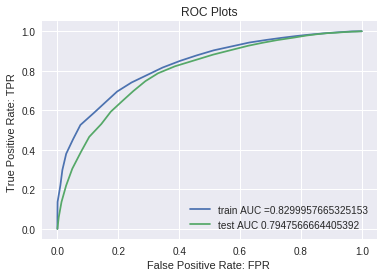

In [100]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc

neigh = KNeighborsClassifier(n_neighbors=best_k_KD_AvgW2V,algorithm = "kd_tree")
neigh.fit(X_train_vectors,y_train_cv)

train_fpr , train_tpr , thresholds = roc_curve(y_train_cv , neigh.predict_proba(X_train_vectors)[:,1])
test_fpr , test_tpr , thresholds = roc_curve(y_test, neigh.predict_proba(X_test_vectors)[:,1])

train_KD_AvgW2V_Acc = auc(train_fpr,train_tpr)
test_KD_AvgW2V_Acc = auc(test_fpr,test_tpr)

plt.plot(train_fpr , train_tpr , label = "train AUC ="+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr , test_tpr , label = "test AUC "+ str(auc(test_fpr,test_tpr)))
plt.legend()
plt.xlabel( "False Positive Rate: FPR " )
plt.ylabel("True Positive Rate: TPR ")
plt.title("ROC Plots")
plt.show()

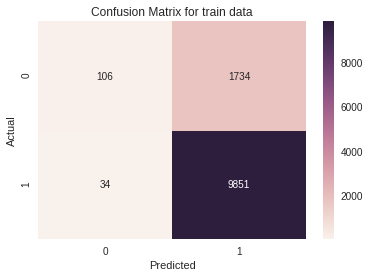

In [56]:
conf_matrix = confusion_matrix(y_train_cv, neigh.predict(X_train_vectors))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

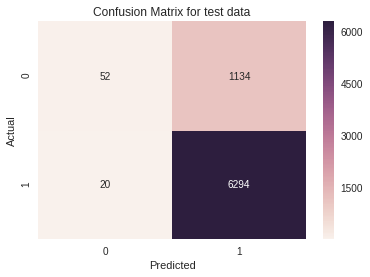

In [57]:
conf_matrix = confusion_matrix(y_test, neigh.predict(X_test_vectors))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [58]:
# Calculating TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test, neigh.predict(X_test_vectors)).ravel()

# TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR " , TPR)

# FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR " , FPR)

# TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR " , TNR)

# FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR " , FNR)


TPR  0.8473344103392568
FPR  0.2777777777777778
TNR  0.7222222222222222
FNR  0.15266558966074315


### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [60]:
# Please write all the code with proper documentation

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
      
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidfw2v.append(sent_vec)
    row += 1
    
    
X_test_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidfw2v.append(sent_vec)
    row += 1
    
    
    
X_cv_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_cv_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_cv_tfidfw2v.append(sent_vec)
    row += 1

100%|██████████| 5775/5775 [01:33<00:00, 61.56it/s]


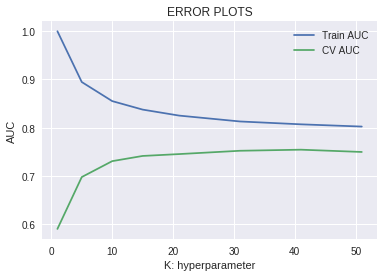

In [61]:
#finding best k- value using loop

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm = "kd_tree")
    neigh.fit(X_train_tfidfw2v, y_train_cv)
    y_train_pred = []
    y_train_pred.extend(neigh.predict_proba(X_train_tfidfw2v)[:,1])  
    y_cv_pred = []
    y_cv_pred.extend(neigh.predict_proba(X_cv_tfidfw2v)[:,1])
    train_auc.append(roc_auc_score(y_train_cv,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
best_k_KD_tfidfw2v = 51

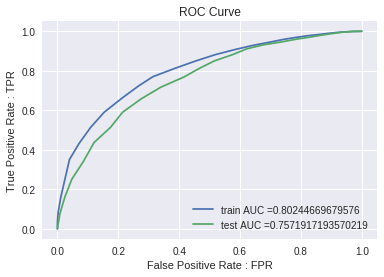

In [102]:
#testing the data

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k_KD_tfidfw2v)
neigh.fit(X_train_tfidfw2v, y_train_cv)

train_fpr, train_tpr, thresholds = roc_curve(y_train_cv, neigh.predict_proba(X_train_tfidfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_tfidfw2v)[:,1])

train_tfidfw2v_KD_Acc = auc(train_fpr, train_tpr)
test_tfidfw2v_KD_Acc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate : FPR")
plt.ylabel("True Positive Rate : TPR")
plt.title("ROC Curve")
plt.show()



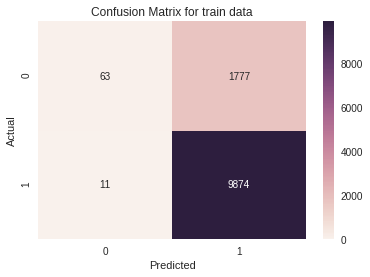

In [64]:
conf_matrix = confusion_matrix(y_train_cv, neigh.predict(X_train_tfidfw2v))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

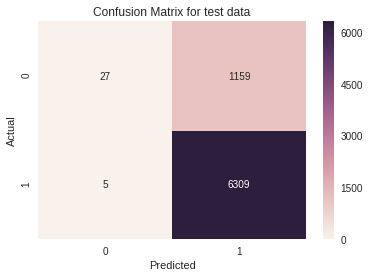

In [65]:
conf_matrix = confusion_matrix(y_test, neigh.predict(X_test_tfidfw2v))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [66]:
# Calculating TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test, neigh.predict(X_test_tfidfw2v)).ravel()

# TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR " , TPR)

# FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR " , FPR)

# TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR " , TNR)

# FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR " , FNR)


TPR  0.8448044991965721
FPR  0.15625
TNR  0.84375
FNR  0.15519550080342795


# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

For Best Model , TPR and TNR shoud be high then FPR and FNR should be low.

Taken some references from Github and sample notebook provided by AAIC.

In [103]:
from prettytable import PrettyTable

names = ["KNN using 'brute' for BoW","KNN using 'brute' for TFIDF","KNN using 'brute' for Avg-Word2Vec",
         "KNN using 'brute' for TFIDF-Word2Vec","KNN using 'kdTree' for BoW",
        "KNN using 'kdTree' for TFIDF",  "KNN using 'kdTree' for Avg-Word2Vec",
         "KNN using 'kdTree' for TFIDF-Word2Vec"]

optimal_K = [best_k_bow, best_k_tfidf, best_k_AVGW2V,best_k_tfidfW2V,             
            best_K_KD_BOW, best_k_KD_tfidf,
            best_k_KD_AvgW2V,best_k_KD_tfidfw2v]

train_acc = [train_BOW_Acc, train_tfidf_Acc,train_AVGW2V_Acc, train_tfidfW2V_Acc,
             train_BOW_KD_Acc, train_tfidf_KD_Acc, train_KD_AvgW2V_Acc, train_tfidfw2v_KD_Acc]

test_acc = [test_BOW_Acc, test_tfidf_Acc, test_AVGW2V_Acc,test_tfidfW2V_Acc,
            test_BOW_KD_Acc, test_tfidf_KD_Acc, test_KD_AvgW2V_Acc, test_tfidfw2v_KD_Acc]

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best K",optimal_K)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+---------------------------------------+--------+--------------------+--------------------+
| S.NO. |                 MODEL                 | Best K | Training Accuracy  |   Test Accuracy    |
+-------+---------------------------------------+--------+--------------------+--------------------+
|   1   |       KNN using 'brute' for BoW       |   51   | 0.7911138692793209 | 0.7505817661547107 |
|   2   |      KNN using 'brute' for TFIDF      |   51   | 0.833249488685096  | 0.7871014971948629 |
|   3   |   KNN using 'brute' for Avg-Word2Vec  |   51   | 0.8299957665325153 | 0.7947566664405392 |
|   4   |  KNN using 'brute' for TFIDF-Word2Vec |   51   |  0.80244669679576  | 0.7571917193570219 |
|   5   |       KNN using 'kdTree' for BoW      |   51   | 0.8067773690923885 | 0.7759449142968248 |
|   6   |      KNN using 'kdTree' for TFIDF     |   35   | 0.8302208000703746 | 0.7803568023306434 |
|   7   |  KNN using 'kdTree' for Avg-Word2Vec  |   51   | 0.8299957665325153 | 0.794756666